In [1]:
from datasets import load_dataset, Image, Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
import torch.optim as optim
import torch
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torch.utils.data import TensorDataset, DataLoader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
labels = pd.read_csv("/kaggle/input/spr-x-ray-age/train_age.csv").sort_values("imageId")["age"].tolist()[:1000]
train_path = "/kaggle/input/spr-x-ray-age/kaggle/kaggle/train/"
train_files = sorted(os.listdir(train_path))[:1000]       
ds = Dataset.from_dict({"image": [f"{train_path}{f}" for f in train_files],
                            "label": labels}).cast_column("image", Image())
ds = ds.train_test_split(test_size=0.2)

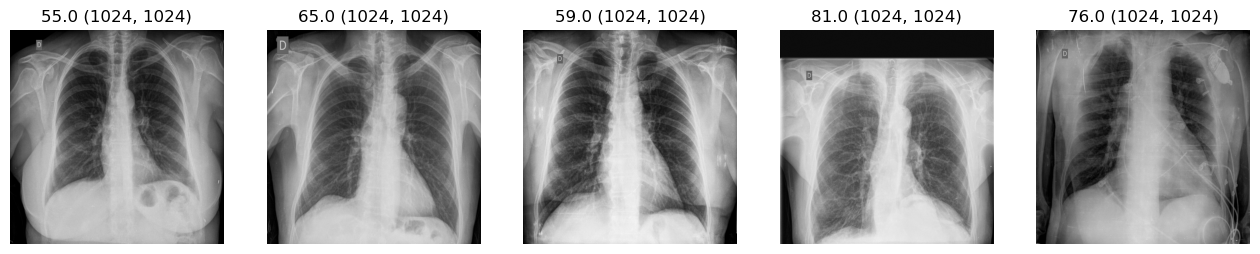

In [3]:
def preview_data(n):
    image_list = ds["train"][:n]["image"]
    labels = ds["train"][:n]["label"]
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(16, 10))
    for i, image in enumerate(image_list):
        axes[i].imshow(image)
        axes[i].set_title(f"{labels[i]} {image.size}")
        axes[i].axis("off")
plt.show()

preview_data(5)

In [4]:
def crop_border(img):
    gs = np.array(img)[..., :3] @ [0.299, 0.587, 0.114]
    rows_to_remove = np.where((gs <= 100).sum(axis=1) == gs.shape[1])[0]
    cols_to_remove = np.where((gs <= 100).sum(axis=0) == gs.shape[0])[0]
    gs = np.delete(gs, rows_to_remove, axis=0)
    gs = np.delete(gs, cols_to_remove, axis=1)
    return PILImage.fromarray(np.uint8(gs) , "L")


def transforms(examples):
#     transform1 = Compose([Resize((224,224))])
    examples["image"] = [crop_border(image).convert("RGB").resize((224,224)) for image in examples["image"]]
    return examples
#     transform2 = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     examples["pixel_values"] = [np.array(image.getdata(), dtype=np.uint8) for image in examples["image"]]
#     return examples

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

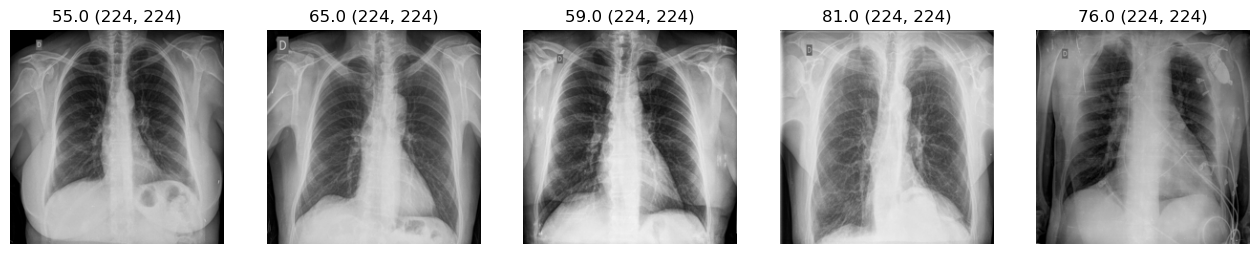

In [5]:
ds = ds.map(transforms, batched=True)
preview_data(5)

In [6]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
train_inputs = processor(images=ds["train"]["image"], return_tensors="pt")["pixel_values"]
val_inputs = processor(images=ds["test"]["image"], return_tensors="pt")["pixel_values"]
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

class NumericOutputLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x
    

# Modify the output layer to output a single scalar value
input_dim = model.classifier.in_features
output_dim = 1  # Set the output dimension to 1 for numeric prediction
model.classifier = NumericOutputLayer(input_dim, output_dim)


# transform = ToTensor()  
# # Define the data loaders for training and validation
train_dataset = TensorDataset(train_inputs, torch.FloatTensor(ds["train"]["label"]))
val_dataset = TensorDataset(val_inputs, torch.FloatTensor(ds["test"]["label"]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)


optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Use the Adam optimizer
loss_fn = nn.L1Loss()  # MAE
num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)
        loss = loss_fn(torch.flatten(outputs.logits), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            loss = loss_fn(torch.flatten(outputs.logits), y_batch)
            val_loss += loss.item() * len(x_batch)
        val_loss /= len(val_dataset)
        print("Epoch {}, Validation Loss: {:.4f}".format(epoch+1, val_loss))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Validation Loss: 47.5854
Epoch 2, Validation Loss: 46.5520
Epoch 3, Validation Loss: 45.3589
Epoch 4, Validation Loss: 43.9808
Epoch 5, Validation Loss: 42.4111
Epoch 6, Validation Loss: 40.6541
Epoch 7, Validation Loss: 38.7186
Epoch 8, Validation Loss: 36.6105
Epoch 9, Validation Loss: 34.3373
Epoch 10, Validation Loss: 31.9871
Epoch 11, Validation Loss: 29.7544
Epoch 12, Validation Loss: 27.7764
Epoch 13, Validation Loss: 26.0242
Epoch 14, Validation Loss: 24.4953
Epoch 15, Validation Loss: 23.1416
